In [1]:
import pandas as pd

In [4]:
from gensim.models import Word2Vec

In [2]:
import networkx as nx
from node2vec import Node2Vec

e:\Code\envs\tesis_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data = pd.read_csv('../Dataset/dataindomaret.csv')

In [11]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,from,Ingredient,to,Labeling
0,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",indomaret keripik tempe sagu,0
1,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",milo healthy drink polybag activ-go,0
2,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",red bull gold energy drink can,0
3,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",matchamu makjamu,0
4,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",nestle air mineral pure life,0


In [8]:
gp = nx.from_pandas_edgelist(data, source='from', target='Labeling')

In [9]:
data2 = data[['to', 'Labeling']]
data2

,to,Labeling
0,indomaret keripik tempe sagu,0
1,milo healthy drink polybag activ-go,0
2,red bull gold energy drink can,0
3,matchamu makjamu,0
4,nestle air mineral pure life,0
...,...,...
159680,indomaret teng teng noga kacang wijen,0
159681,red bull gold energy drink can,0
159682,big babol candy stick strawberry,0
159683,buavita juice slim apple,0


In [10]:
produk = data2.values.tolist()

In [ ]:
produk

In [11]:
gp.add_edges_from(produk)

In [12]:
node2vec = Node2Vec(gp, dimensions=100, walk_length=80, num_walks=10, workers=4)

Computing transition probabilities: 100%|██████████| 430/430 [00:00<00:00, 688.16it/s]


In [13]:
model = node2vec.fit(window=5, min_count=1)

In [14]:
model.wv.save_word2vec_format('node2vec.n2v')

In [15]:
model.save('model.n2v')

In [5]:
model = Word2Vec.load('model.n2v')

In [6]:
import numpy as np

In [7]:
def vectorOfTweet(tokens, model):
    if not len(tokens):
        return np.zeros(100)
    
    v = list()
    for token in tokens:
        if token in model:
            # If there is a coresponding vector in the model, add it to the list
            v.append(model[token])
        else:
            # else, make a random one
            v.append((np.random.rand(100)*2 - 1)) # p.x. len(w2vModel['obama']) 
    
    # Compute the mean vector
    summ = np.zeros(100) #
    for vector in v:
        summ += vector
    return summ/len(v)

In [12]:
vectors = list()
# for every tweet
for index, row in data.iterrows():
    vectors.append(vectorOfTweet(data.loc[index,'from'], model.wv))

# Save the vectors as a new column in the dataframe
data['Node2Vec'] = pd.Series(vectors,index=data.index)

In [13]:
data.head()

,from,Ingredient,to,Labeling,Node2Vec
0,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",indomaret keripik tempe sagu,0,"[0.006886432503407258, -0.2474197398196401, 0...."
1,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",milo healthy drink polybag activ-go,0,"[-0.015052488020518602, -0.01787767954791804, ..."
2,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",red bull gold energy drink can,0,"[0.12405821245021915, 0.02881321045538881, -0...."
3,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",matchamu makjamu,0,"[0.16877358590560884, -0.027997558838598318, 0..."
4,3 ayam mie telor super merah,"tepung terigu, garam, tepung telur, pemantap, ...",nestle air mineral pure life,0,"[-0.15960886038074287, -0.11700545356153323, -..."


In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [27]:
#RsnfomForest
RF = RandomForestClassifier()

ss = 1, 0.5, 0.33
train_size = [0.7]
clf = [RF]
#, NB, SVM, LR, GBT
for clfs in clf :
    for s in ss:
        X = data['Node2Vec'].tolist()
        y = data['Labeling']

        over = SMOTE(sampling_strategy=0.02)
        under = RandomUnderSampler(sampling_strategy=s)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        
        X, y = pipeline.fit_resample(X, y)
        for f in train_size :
        
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
            clfs.fit(X_train, y_train)
            #score_test = rf.score(X_test, y_test)
            predict = clfs.predict(X_test)
            score_test1 = metrics.f1_score(y_test, predict)
            print("F1-Score Random Forest with Train size %.2f : %.4f" % (f, score_test1))
    
            score_test3 = metrics.precision_score(y_test, predict)
            print("Precision Random Forest with Train size %.2f : %.4f" % (f, score_test3))
     
            score_test4 = metrics.recall_score(y_test, predict)
            print("Recall Random Forest with Train size %.2f : %.4f" % (f, score_test4))

            score_test2 = metrics.accuracy_score(y_test, predict)
            print("Accuracy Random Forest with Train size %.2f : %.4f" % (f, score_test2))

F1-Score Random Forest with Train size 0.70 : 0.9529
Precision Random Forest with Train size 0.70 : 0.9727
Recall Random Forest with Train size 0.70 : 0.9340
Accuracy Random Forest with Train size 0.70 : 0.9540
F1-Score Random Forest with Train size 0.70 : 0.9158
Precision Random Forest with Train size 0.70 : 0.9963
Recall Random Forest with Train size 0.70 : 0.8473
Accuracy Random Forest with Train size 0.70 : 0.9487
F1-Score Random Forest with Train size 0.70 : 0.8796
Precision Random Forest with Train size 0.70 : 1.0000
Recall Random Forest with Train size 0.70 : 0.7850
Accuracy Random Forest with Train size 0.70 : 0.9486


In [25]:
#SVM Classifier
RF = SVC()

ss = 1, 0.5, 0.33
train_size = [0.7]
clf = [RF]
#, NB, SVM, LR, GBT
for clfs in clf :
    for s in ss:
        X = data['Node2Vec'].tolist()
        y = data['Labeling']

        over = SMOTE(sampling_strategy=0.02)
        under = RandomUnderSampler(sampling_strategy=s)
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        
        X, y = pipeline.fit_resample(X, y)
        for f in train_size :
        
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
            clfs.fit(X_train, y_train)
            #score_test = rf.score(X_test, y_test)
            predict = clfs.predict(X_test)
            score_test1 = metrics.f1_score(y_test, predict)
            print("F1-Score SVM with Train size %.2f : %.4f" % (f, score_test1))
    
            score_test3 = metrics.precision_score(y_test, predict)
            print("Precision SVM with Train size %.2f : %.4f" % (f, score_test3))
     
            score_test4 = metrics.recall_score(y_test, predict)
            print("Recall SVM with Train size %.2f : %.4f" % (f, score_test4))

            score_test2 = metrics.accuracy_score(y_test, predict)
            print("Accuracy SVM with Train size %.2f : %.4f" % (f, score_test2))

F1-Score SVM with Train size 0.70 : 0.9770
Precision SVM with Train size 0.70 : 0.9740
Recall SVM with Train size 0.70 : 0.9801
Accuracy SVM with Train size 0.70 : 0.9770
F1-Score SVM with Train size 0.70 : 0.9691
Precision SVM with Train size 0.70 : 0.9911
Recall SVM with Train size 0.70 : 0.9480
Accuracy SVM with Train size 0.70 : 0.9801
F1-Score SVM with Train size 0.70 : 0.9671
Precision SVM with Train size 0.70 : 0.9931
Recall SVM with Train size 0.70 : 0.9425
Accuracy SVM with Train size 0.70 : 0.9847


SMOTE

In [28]:
#Smote for ss 0.02
RF = RandomForestClassifier()

X = data['Node2Vec'].tolist()
y = data['Labeling']
        
over = SMOTE(sampling_strategy=0.02)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

from collections import Counter
counter = Counter(y)
print(counter)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
RF.fit(X_train, y_train)
#score_test = rf.score(X_test, y_test)
predict = RF.predict(X_test)
score_test1 = metrics.f1_score(y_test, predict)
score_test2 = metrics.precision_score(y_test, predict)
score_test3 = metrics.recall_score(y_test, predict)
score_test4 = metrics.accuracy_score(y_test, predict)
print("F1 Score = ", score_test1)
print("Precision = ",score_test2)
print("Recall = ",score_test3)
print("Accuracy = ",score_test4)

Counter({0: 3186, 1: 3186})
F1 Score =  0.9519743863393809
Precision =  0.9695652173913043
Recall =  0.9350104821802935
Accuracy =  0.952928870292887


In [29]:
#Smote for ss 0.05
RF = RandomForestClassifier()

X = data['Node2Vec'].tolist()
y = data['Labeling']
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

from collections import Counter
counter = Counter(y)
print(counter)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
RF.fit(X_train, y_train)
#score_test = rf.score(X_test, y_test)
predict = RF.predict(X_test)
score_test1 = metrics.f1_score(y_test, predict)
score_test2 = metrics.precision_score(y_test, predict)
score_test3 = metrics.recall_score(y_test, predict)
score_test4 = metrics.accuracy_score(y_test, predict)
print("F1 Score = ", score_test1)
print("Precision = ",score_test2)
print("Recall = ",score_test3)
print("Accuracy = ",score_test4)

Counter({0: 7967, 1: 7967})
F1 Score =  0.9872624765086656
Precision =  0.9899497487437185
Recall =  0.9845897542690546
Accuracy =  0.9872411629366241


In [30]:
#Smote SVM for ss 0.02
SVM = SVC()

X = data['Node2Vec'].tolist()
y = data['Labeling']
        
over = SMOTE(sampling_strategy=0.02)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

from collections import Counter
counter = Counter(y)
print(counter)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
SVM.fit(X_train, y_train)
#score_test = rf.score(X_test, y_test)
predict = SVM.predict(X_test)
score_test1 = metrics.f1_score(y_test, predict)
score_test2 = metrics.precision_score(y_test, predict)
score_test3 = metrics.recall_score(y_test, predict)
score_test4 = metrics.accuracy_score(y_test, predict)
print("F1 Score = ", score_test1)
print("Precision = ",score_test2)
print("Recall = ",score_test3)
print("Accuracy = ",score_test4)

Counter({0: 3186, 1: 3186})
F1 Score =  0.9873417721518988
Precision =  0.9936305732484076
Recall =  0.9811320754716981
Accuracy =  0.9874476987447699


In [31]:
#Smote SVM for ss 0.05
SVM = SVC()

X = data['Node2Vec'].tolist()
y = data['Labeling']
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

from collections import Counter
counter = Counter(y)
print(counter)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
SVM.fit(X_train, y_train)
#score_test = rf.score(X_test, y_test)
predict = SVM.predict(X_test)
score_test1 = metrics.f1_score(y_test, predict)
score_test2 = metrics.precision_score(y_test, predict)
score_test3 = metrics.recall_score(y_test, predict)
score_test4 = metrics.accuracy_score(y_test, predict)
print("F1 Score = ", score_test1)
print("Precision = ",score_test2)
print("Recall = ",score_test3)
print("Accuracy = ",score_test4)

Counter({0: 7967, 1: 7967})
F1 Score =  0.9859803306130991
Precision =  0.990748528174937
Recall =  0.9812578092461475
Accuracy =  0.9859861953566199


Tuning Parameters

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [76]:
X = data['Node2Vec'].tolist()
y = data['Labeling']

over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [1, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [80, 90],
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
datakuh = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='f1',
                          cv = 5, n_jobs = -1)

In [77]:
datakuh.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [80, 90],
                         'n_estimators': [1, 10, 50, 100]},
             scoring='f1')

In [78]:
datakuh.best_params_

{'criterion': 'entropy', 'max_depth': 90, 'n_estimators': 100}

In [86]:
datakuh.best_score_

0.9867781220698333

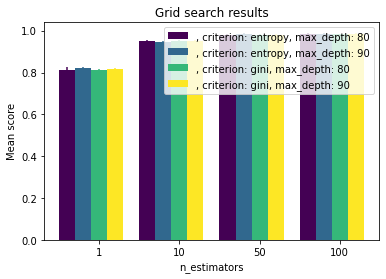

In [81]:
from sklearn_evaluation.plot import grid_search
from matplotlib import pyplot as plt
grid_search(datakuh.cv_results_, change='n_estimators', kind='bar')
plt.show()

In [ ]:
{'criterion': 'entropy', 'max_depth': 90, 'n_estimators': 100}

In [ ]:
RF = RandomForestClassifier()

In [87]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = data['Node2Vec'].tolist()
y = data['Labeling']
    
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(max_depth = 90, n_estimators = 100, criterion = 'entropy')
rf.fit(X_train, y_train)
            
predict = rf.predict(X_test)

from sklearn.model_selection import cross_val_score
score_test = metrics.f1_score(y_test, predict)
print(cross_val_score(rf, X, y, cv=kfold, scoring="f1").mean())

0.9909716789227403


In [44]:
print(cross_val_score(rf, X, y, cv=kfold, scoring="f1").mean())

0.9920400807840712


Perbandingan Performa Model

In [88]:
#Model Default

X = data['Node2Vec'].tolist()
y = data['Labeling']
    
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

#Node2Vec
RF = RandomForestClassifier()

ss = 1, 0.5, 0.33
train_size = [0.8, 0.75, 0.7, 0.6]
clf = [RF]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#, NB, SVM, LR, GBT
for clfs in clf :
    for f in train_size :
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
        clfs.fit(X_train, y_train)
        #score_test = rf.score(X_test, y_test)
        predict = clfs.predict(X_test)
        score_test = metrics.f1_score(y_test, predict)
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1"))
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1").mean())

[0.98883375 0.98993077 0.99004176 0.99338583 0.98405752]
0.9894544283428613
[0.98604651 0.99024237 0.99068423 0.98958004 0.98722343]
0.9893243277836479
[0.98698885 0.98961938 0.98971061 0.99150676 0.98723934]
0.9888074727588174
[0.98886827 0.98836112 0.9903599  0.99150676 0.98630989]
0.9892025228336984


In [89]:
#Model dengan Tuning parameter RandomForest

X = data['Node2Vec'].tolist()
y = data['Labeling']
    
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

#Node2Vec
RF = RandomForestClassifier(max_depth = 90, n_estimators = 100, criterion = 'entropy')

ss = 1, 0.5, 0.33
train_size = [0.8, 0.75, 0.7, 0.6]
clf = [RF]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#, NB, SVM, LR, GBT
for clfs in clf :
    for f in train_size :
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
        clfs.fit(X_train, y_train)
        #score_test = rf.score(X_test, y_test)
        predict = clfs.predict(X_test)
        score_test = metrics.f1_score(y_test, predict)
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1"))
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1").mean())

[0.99076355 0.99276502 0.99197432 0.9902239  0.99005594]
0.9906629141912069
[0.99104662 0.99369483 0.99229287 0.99117832 0.99126638]
0.9910960856742232
[0.98983051 0.99306868 0.99230769 0.99087189 0.98971642]
0.9909061979539283
[0.99075786 0.99274219 0.99325843 0.98898332 0.99064255]
0.9911592167533566


Model dengan Performa terbaik

In [90]:
#Node2Vec
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = data['Node2Vec'].tolist()
y = data['Labeling']
        
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
RF = RandomForestClassifier(max_depth = 90, n_estimators = 100, criterion = 'entropy')

In [91]:
kFold = 5
print(cross_val_score(RF, X, y, cv=kfold, scoring="accuracy"))
print(cross_val_score(RF, X, y, cv=kfold, scoring="accuracy").mean())
print(cross_val_score(RF, X, y, cv=kfold, scoring="precision"))
print(cross_val_score(RF, X, y, cv=kfold, scoring="precision").mean())
print(cross_val_score(RF, X, y, cv=kfold, scoring="recall"))
print(cross_val_score(RF, X, y, cv=kfold, scoring="recall").mean())
print(cross_val_score(RF, X, y, cv=kfold, scoring="f1"))
print(cross_val_score(RF, X, y, cv=kfold, scoring="f1").mean())

[0.99372451 0.98995921 0.99152808 0.99058676 0.99089768]
0.9912136187284698
[0.9919852  0.99240506 0.98978289 0.99369483 0.99127182]
0.9910949635430317
[0.9919852  0.9905482  0.99486521 0.99182904 0.98756992]
0.9904717846359162
[0.99291654 0.99116719 0.99133782 0.99245283 0.9894081 ]
0.9912758781536016


In [51]:
dataku.best_score_

0.9877609183390337

In [52]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0: 7967, 1: 7967})


Support Vector Machine

In [101]:
X = data['Node2Vec'].tolist()
y = data['Labeling']

over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Create the parameter grid based on the results of random search 
param_grid = {
    'C': [1.0, 2.0],
    'kernel': ['linear', 'rbf'],
    'degree': [1, 2, 3, 4]
}
# Create a based model
SV = SVC()
# Instantiate the grid search model
datakuh2 = GridSearchCV(estimator = SV, param_grid = param_grid, scoring='f1',
                          cv = 5)

In [102]:
datakuh2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1.0, 2.0], 'degree': [1, 2, 3, 4],
                         'kernel': ['linear', 'rbf']},
             scoring='f1')

In [104]:
datakuh2.best_score_

0.9983856492500346

In [103]:
datakuh2.best_params_

{'C': 2.0, 'degree': 1, 'kernel': 'rbf'}

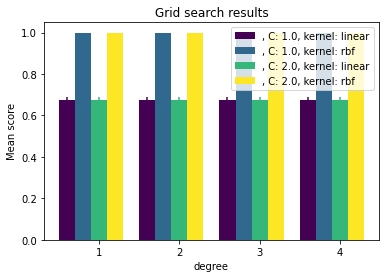

In [105]:
from sklearn_evaluation.plot import grid_search
from matplotlib import pyplot as plt
grid_search(datakuh2.cv_results_, change='degree', kind='bar')
plt.show()

In [95]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = data['Node2Vec'].tolist()
y = data['Labeling']
    
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

sv = SVC(C= 2.0, degree= 1, kernel= 'rbf')
sv.fit(X_train, y_train)
            
predict = rf.predict(X_test)

from sklearn.model_selection import cross_val_score
score_test = metrics.f1_score(y_test, predict)
print(cross_val_score(sv, X, y, cv=kfold, scoring="f1").mean())

0.9990586651232611


Perbandingan Performa Model SVM

In [106]:
#Model Default

X = data['Node2Vec'].tolist()
y = data['Labeling']
    
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

#Node2Vec
SVM = SVC()

ss = 1, 0.5, 0.33
train_size = [0.8, 0.75, 0.7, 0.6]
clf = [SVM]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#, NB, SVM, LR, GBT
for clfs in clf :
    for f in train_size :
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
        clfs.fit(X_train, y_train)
        #score_test = rf.score(X_test, y_test)
        predict = clfs.predict(X_test)
        score_test = metrics.f1_score(y_test, predict)
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1"))
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1").mean())

[0.99876847 0.99874135 0.99871795 0.99905808 0.99875854]
0.998808877645415
[0.99876847 0.99874135 0.99871795 0.99905808 0.99875854]
0.998808877645415
[0.99876847 0.99874135 0.99871795 0.99905808 0.99875854]
0.998808877645415
[0.99876847 0.99874135 0.99871795 0.99905808 0.99875854]
0.998808877645415


In [65]:
#Model dengan Tuning parameter SVM

X = data['Node2Vec'].tolist()
y = data['Labeling']
    
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

#Node2Vec
SVM = SVC(C= 2.0, degree= 1, kernel= 'rbf')

ss = 1, 0.5, 0.33
train_size = [0.8, 0.75, 0.7, 0.6]
clf = [SVM]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#, NB, SVM, LR, GBT
for clfs in clf :
    for f in train_size :
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
        clfs.fit(X_train, y_train)
        #score_test = rf.score(X_test, y_test)
        predict = clfs.predict(X_test)
        score_test = metrics.f1_score(y_test, predict)
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1"))
        print(cross_val_score(clfs, X, y, cv=kfold, scoring="f1").mean())

[0.99938386 0.99937028 0.99935856 0.99937186 0.99968934]
0.9994347802255724
[0.99938386 0.99937028 0.99935856 0.99937186 0.99968934]
0.9994347802255724
[0.99938386 0.99937028 0.99935856 0.99937186 0.99968934]
0.9994347802255724
[0.99938386 0.99937028 0.99935856 0.99937186 0.99968934]
0.9994347802255724


Model dengan Performa terbaik

In [107]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = data['Node2Vec'].tolist()
y = data['Labeling']
        
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
SVM = SVC(C= 2.0, degree= 1, kernel= 'rbf')

In [108]:
kFold = 5
print(cross_val_score(SVM, X, y, cv=kfold, scoring="f1"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="f1").mean())
print(cross_val_score(SVM, X, y, cv=kfold, scoring="accuracy"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="accuracy").mean())
print(cross_val_score(SVM, X, y, cv=kfold, scoring="precision"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="precision").mean())
print(cross_val_score(SVM, X, y, cv=kfold, scoring="recall"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="recall").mean())

[1.         0.99874135 0.99903815 0.99874451 0.99875854]
0.9990565084607368
[1.         0.9987449  0.99905868 0.9987449  0.99874451]
0.9990585970823483
[1.         0.99748586 0.99807816 0.99749216 0.99752015]
0.9981152649560558
[1. 1. 1. 1. 1.]
1.0


In [109]:
kFold = 5
print(cross_val_score(SVM, X, y, cv=kfold, scoring="f1"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="f1").mean())
print(cross_val_score(SVM, X, y, cv=kfold, scoring="accuracy"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="accuracy").mean())
print(cross_val_score(SVM, X, y, cv=kfold, scoring="precision"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="precision").mean())
print(cross_val_score(SVM, X, y, cv=kfold, scoring="recall"))
print(cross_val_score(SVM, X, y, cv=kfold, scoring="recall").mean())

[1.         0.99874135 0.99903815 0.99874451 0.99875854]
0.9990565084607368
[1.         0.9987449  0.99905868 0.9987449  0.99874451]
0.9990585970823483
[1.         0.99748586 0.99807816 0.99749216 0.99752015]
0.9981152649560558
[1. 1. 1. 1. 1.]
1.0


In [110]:
datakuh2.best_params_

{'C': 2.0, 'degree': 1, 'kernel': 'rbf'}

Visualisasi ROC

In [18]:
X = data['Node2Vec'].tolist()
y = data['Labeling']

over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
        
X, y = pipeline.fit_resample(X, y)
# Membandingkan Decision Tree dengan berbagai train size
RF = RandomForestClassifier(max_depth = 90, n_estimators = 100, criterion='entropy')
SVM = SVC(C= 2.0, degree= 1, kernel= 'rbf', probability=True)

train_size = [0.7]
rforest = [RF, SVM]
for rf in rforest :
  for f in train_size :
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=f, random_state=42)
    
    rf.fit(X_train, y_train)
    #score_test = rf.score(X_test, y_test)
    predict = rf.predict(X_test)
    score_test1 = metrics.f1_score(y_test, predict)
    if rf == RF: print("F1-Score Random Forest with Train size %.2f : %.3f%%" % (f, score_test1*100))
    if rf == SVM: print("F1-Score NB with Train size %.2f : %.3f%%" % (f, score_test1*100))

F1-Score Random Forest with Train size 0.70 : 98.917%
F1-Score NB with Train size 0.70 : 99.896%


In [19]:
rf_probs1 = RF.predict_proba(X_test)
rf_probs1 = rf_probs1[:, 1]
svm_probs1 = SVM.predict_proba(X_test)
svm_probs1 = svm_probs1[:, 1]

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [21]:
rf_auc1 = roc_auc_score(y_test,rf_probs1)
svm_auc1 = roc_auc_score(y_test,svm_probs1)

print('Random Forest = %.3f' % (rf_auc1))
print('SVM = %.3f' % (svm_auc1))

Random Forest = 0.999
SVM = 1.000


In [22]:
rf_rpr1, rf_tpr1, _ = roc_curve(y_test, rf_probs1)
nb_rpr1, nb_tpr1, _ = roc_curve(y_test, svm_probs1)

In [24]:
from matplotlib import pyplot as plt

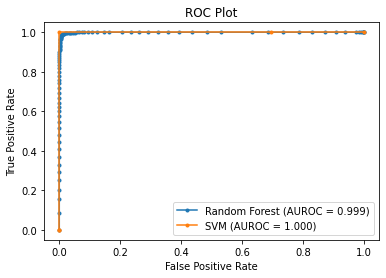

In [25]:
plt.plot(rf_rpr1, rf_tpr1, marker= '.', label = 'Random Forest (AUROC = %0.3f)' % rf_auc1)
plt.plot(nb_rpr1, nb_tpr1, marker= '.', label = 'SVM (AUROC = %0.3f)' % svm_auc1)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()